In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

%matplotlib inline

from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from IPython.display import Image

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive/generate'

/content/gdrive/My Drive/generate


In [5]:
IMAGE_DIR = 'data'
RESULTS_DIR = 'output'

image_size = 64
batch_size = 16

normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

# dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
# dataset = ConcatDataset(dataset_list)
dataset = normal_dataset

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

In [7]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

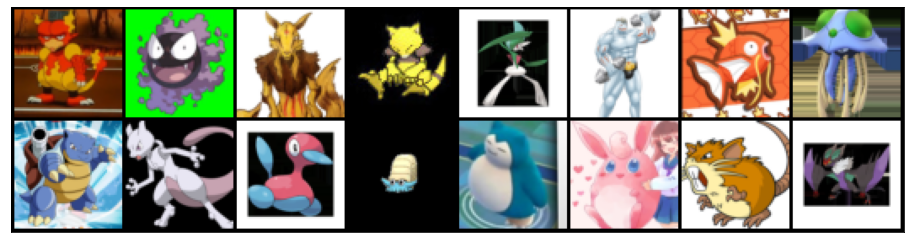

In [9]:
show_batch(dataloader)

In [10]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [11]:
generator = nn.Sequential(
    nn.ConvTranspose2d(16, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
)

In [12]:
def get_training_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dataloader)

In [13]:
device = get_training_device()
dev_dataloader = DeviceDataLoader(dataloader, device)

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

device

device(type='cuda')

In [14]:
def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()
    
    real_predictions = discriminator(real_pokemon)
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()

    latent_batch = torch.randn(batch_size, 16, 1, 1, device=device)

    fake_pokemon = generator(latent_batch)

    gen_predictions = discriminator(fake_pokemon)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() 

    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    
    return total_loss.item(), real_score, gen_score

In [15]:
def train_generator(gen_optimizer):
    gen_optimizer.zero_grad()

    latent_batch = torch.randn(batch_size, 16, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)

    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
    loss = F.binary_cross_entropy(disc_predictions, targets)
    loss.backward()
    gen_optimizer.step()

    return loss.item()

In [16]:
def save_results(index, latent_batch, show=True):
    fake_pokemon = generator(latent_batch)
    fake_file = "{0:0=4d}.png".format(index)
    
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Results Saved")
    
    if show:
        fig, ax = plt.subplots(figsize=(16, 16))
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()

    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    for epoch in range(epochs):
        for real_img, _ in tqdm(dev_dataloader):
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)
            gen_loss = train_generator(gen_optimizer)

        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch + start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        save_results(epoch + start_idx, torch.randn(64, 16, 1, 1, device=device), show=False)
    
    return disc_losses, disc_scores, gen_losses, gen_scores

In [18]:
learning_rate = 0.0025
epochs = 64

history = train(epochs, learning_rate)


Epoch [1/64], gen_loss: 1.8839, disc_loss: 1.1029, real_score: 0.4731, gen_score: 0.7372
Results Saved



Epoch [2/64], gen_loss: 2.5910, disc_loss: 0.7255, real_score: 0.3288, gen_score: 0.8843
Results Saved



Epoch [3/64], gen_loss: 2.6816, disc_loss: 0.7469, real_score: 0.1477, gen_score: 0.7010
Results Saved



Epoch [4/64], gen_loss: 3.1459, disc_loss: 0.9245, real_score: 0.3780, gen_score: 0.7805
Results Saved



Epoch [5/64], gen_loss: 2.8017, disc_loss: 0.6483, real_score: 0.2471, gen_score: 0.8645
Results Saved



Epoch [6/64], gen_loss: 3.2545, disc_loss: 0.9205, real_score: 0.3562, gen_score: 0.7908
Results Saved



Epoch [7/64], gen_loss: 2.8041, disc_loss: 0.6299, real_score: 0.0241, gen_score: 0.7615
Results Saved



Epoch [8/64], gen_loss: 2.8196, disc_loss: 0.5045, real_score: 0.2052, gen_score: 0.9654
Results Saved



Epoch [9/64], gen_loss: 3.2724, disc_loss: 0.4756, real_score: 0.1396, gen_score: 0.9496
Results Saved



Epoch [10/64], gen_loss: 3.2836, disc_loss: 0.4529, real_score: 0.0937, gen_score: 0.9089
Results Saved



Epoch [11/64], gen_loss: 3.9916, disc_loss: 0.4410, real_score: 0.0557, gen_score: 0.9260
Results Saved



Epoch [12/64], gen_loss: 3.0032, disc_loss: 0.6575, real_score: 0.2493, gen_score: 0.9531
Results Saved



Epoch [13/64], gen_loss: 4.4923, disc_loss: 0.7371, real_score: 0.1086, gen_score: 0.6740
Results Saved



Epoch [14/64], gen_loss: 3.6435, disc_loss: 0.5445, real_score: 0.1296, gen_score: 0.9459
Results Saved



Epoch [15/64], gen_loss: 1.3166, disc_loss: 0.4444, real_score: 0.0571, gen_score: 0.9452
Results Saved



Epoch [16/64], gen_loss: 3.0310, disc_loss: 0.7886, real_score: 0.1119, gen_score: 0.6831
Results Saved



Epoch [17/64], gen_loss: 4.3405, disc_loss: 0.7056, real_score: 0.0158, gen_score: 0.6727
Results Saved



Epoch [18/64], gen_loss: 3.8221, disc_loss: 0.5093, real_score: 0.0240, gen_score: 0.8529
Results Saved



Epoch [19/64], gen_loss: 3.7051, disc_loss: 0.4889, real_score: 0.0894, gen_score: 0.9908
Results Saved



Epoch [20/64], gen_loss: 2.3795, disc_loss: 0.4979, real_score: 0.0721, gen_score: 0.9432
Results Saved



Epoch [21/64], gen_loss: 0.7830, disc_loss: 0.9252, real_score: 0.4100, gen_score: 0.9962
Results Saved



Epoch [22/64], gen_loss: 1.5128, disc_loss: 0.5299, real_score: 0.2332, gen_score: 0.9816
Results Saved



Epoch [23/64], gen_loss: 6.2391, disc_loss: 0.4811, real_score: 0.0470, gen_score: 0.9189
Results Saved



Epoch [24/64], gen_loss: 4.0061, disc_loss: 1.1186, real_score: 0.5751, gen_score: 0.9874
Results Saved



Epoch [25/64], gen_loss: 3.7742, disc_loss: 0.4244, real_score: 0.0887, gen_score: 0.9688
Results Saved



Epoch [26/64], gen_loss: 1.9376, disc_loss: 0.7515, real_score: 0.3465, gen_score: 0.9733
Results Saved



Epoch [27/64], gen_loss: 4.4189, disc_loss: 0.4767, real_score: 0.0327, gen_score: 0.8735
Results Saved



Epoch [28/64], gen_loss: 4.0460, disc_loss: 0.7627, real_score: 0.3841, gen_score: 0.9659
Results Saved



Epoch [29/64], gen_loss: 3.4469, disc_loss: 0.4444, real_score: 0.1359, gen_score: 0.9693
Results Saved



Epoch [30/64], gen_loss: 3.1085, disc_loss: 0.7004, real_score: 0.0558, gen_score: 0.6668
Results Saved



Epoch [31/64], gen_loss: 3.3117, disc_loss: 0.5659, real_score: 0.2160, gen_score: 0.9848
Results Saved



Epoch [32/64], gen_loss: 3.0103, disc_loss: 0.4938, real_score: 0.1018, gen_score: 0.8736
Results Saved



Epoch [33/64], gen_loss: 2.9268, disc_loss: 0.6408, real_score: 0.0228, gen_score: 0.7178
Results Saved



Epoch [34/64], gen_loss: 3.5060, disc_loss: 0.4288, real_score: 0.0196, gen_score: 0.9377
Results Saved



Epoch [35/64], gen_loss: 2.2982, disc_loss: 0.5523, real_score: 0.2096, gen_score: 0.9692
Results Saved



Epoch [36/64], gen_loss: 2.7998, disc_loss: 0.3755, real_score: 0.0717, gen_score: 0.9545
Results Saved



Epoch [37/64], gen_loss: 1.6597, disc_loss: 0.4191, real_score: 0.0959, gen_score: 0.9845
Results Saved



Epoch [38/64], gen_loss: 3.0958, disc_loss: 0.5925, real_score: 0.1911, gen_score: 0.9917
Results Saved



Epoch [39/64], gen_loss: 3.4312, disc_loss: 0.5059, real_score: 0.0210, gen_score: 0.8989
Results Saved



Epoch [40/64], gen_loss: 4.3816, disc_loss: 0.4494, real_score: 0.0950, gen_score: 0.9899
Results Saved



Epoch [41/64], gen_loss: 3.9310, disc_loss: 0.5955, real_score: 0.0147, gen_score: 0.7832
Results Saved



Epoch [42/64], gen_loss: 2.4011, disc_loss: 0.4646, real_score: 0.0728, gen_score: 0.9541
Results Saved



Epoch [43/64], gen_loss: 3.8220, disc_loss: 0.5743, real_score: 0.1456, gen_score: 0.7994
Results Saved



Epoch [44/64], gen_loss: 3.1251, disc_loss: 0.4960, real_score: 0.1324, gen_score: 0.9428
Results Saved



Epoch [45/64], gen_loss: 2.0623, disc_loss: 0.5035, real_score: 0.1646, gen_score: 0.9514
Results Saved



Epoch [46/64], gen_loss: 2.8304, disc_loss: 0.4024, real_score: 0.1104, gen_score: 0.9490
Results Saved



Epoch [47/64], gen_loss: 2.7270, disc_loss: 0.5423, real_score: 0.0222, gen_score: 0.8193
Results Saved



Epoch [48/64], gen_loss: 3.2472, disc_loss: 0.4537, real_score: 0.1840, gen_score: 0.9682
Results Saved



Epoch [49/64], gen_loss: 1.5584, disc_loss: 0.4553, real_score: 0.0790, gen_score: 0.8710
Results Saved



Epoch [50/64], gen_loss: 2.9262, disc_loss: 0.5271, real_score: 0.1856, gen_score: 0.9450
Results Saved



Epoch [51/64], gen_loss: 1.9589, disc_loss: 0.4046, real_score: 0.0333, gen_score: 0.9700
Results Saved



Epoch [52/64], gen_loss: 2.1034, disc_loss: 0.4893, real_score: 0.0755, gen_score: 0.8920
Results Saved



Epoch [53/64], gen_loss: 3.9250, disc_loss: 0.3978, real_score: 0.0270, gen_score: 0.9510
Results Saved



Epoch [54/64], gen_loss: 3.6362, disc_loss: 0.4685, real_score: 0.1793, gen_score: 0.9893
Results Saved



Epoch [55/64], gen_loss: 2.3158, disc_loss: 0.5051, real_score: 0.0073, gen_score: 0.8619
Results Saved



Epoch [56/64], gen_loss: 4.5180, disc_loss: 0.5357, real_score: 0.0342, gen_score: 0.7657
Results Saved



Epoch [57/64], gen_loss: 2.4457, disc_loss: 0.4747, real_score: 0.0146, gen_score: 0.9152
Results Saved



Epoch [58/64], gen_loss: 3.4367, disc_loss: 0.4372, real_score: 0.1054, gen_score: 0.8996
Results Saved



Epoch [59/64], gen_loss: 3.2095, disc_loss: 0.4743, real_score: 0.0850, gen_score: 0.8470
Results Saved



Epoch [60/64], gen_loss: 2.5939, disc_loss: 0.4333, real_score: 0.0354, gen_score: 0.9308
Results Saved



Epoch [61/64], gen_loss: 4.2412, disc_loss: 0.4880, real_score: 0.0934, gen_score: 0.9857
Results Saved



Epoch [62/64], gen_loss: 3.5455, disc_loss: 0.4828, real_score: 0.0189, gen_score: 0.8765
Results Saved



Epoch [63/64], gen_loss: 3.4304, disc_loss: 0.4848, real_score: 0.0229, gen_score: 0.7766
Results Saved



Epoch [64/64], gen_loss: 2.1632, disc_loss: 0.8073, real_score: 0.4290, gen_score: 0.9618
Results Saved


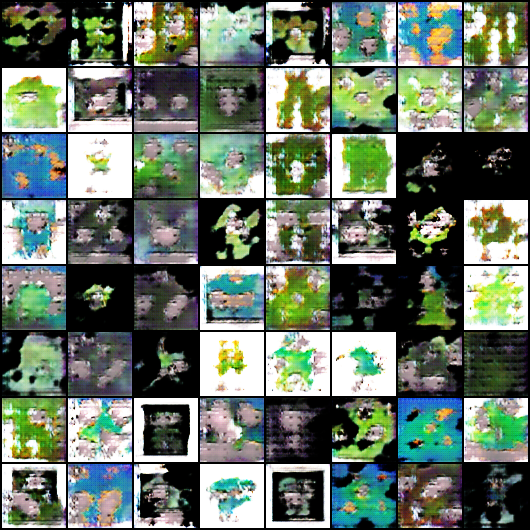

In [19]:
Image('output/0016.png')

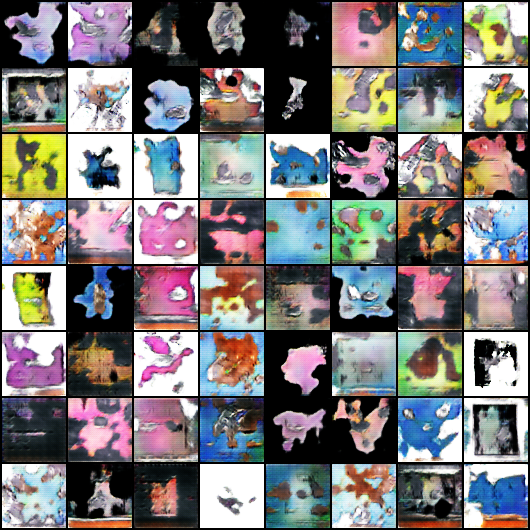

In [20]:
Image('output/0032.png')

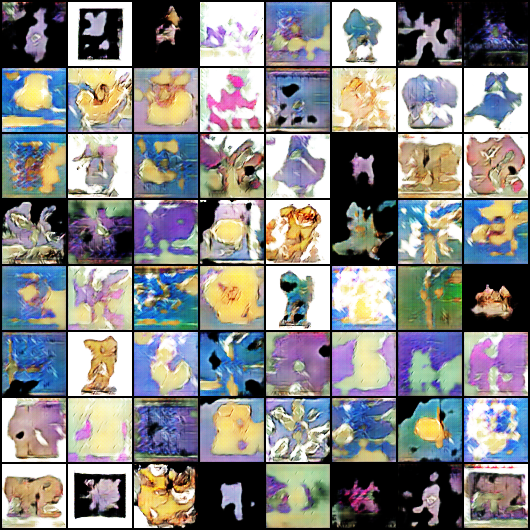

In [21]:
Image('output/0048.png')

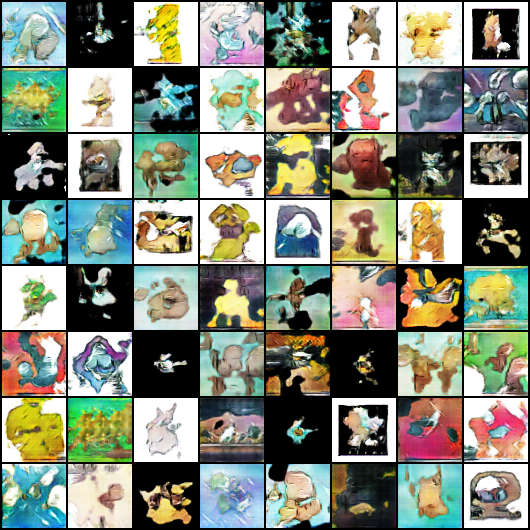

In [22]:
Image('output/0064.png')